<h3>gurobiとoptunaを用いて、最適なパラメータを探索する</h3>

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import xml.etree.ElementTree as ET
from neal import SimulatedAnnealingSampler

from functions import *

In [2]:
n_trials=100

Tall = 400
interval=20
alpha, gamma = 1, 10
yellow_signal_time, lam = 2, 2

In [3]:
# 最適化用に一部書き換えたデータ
new_net_path = 'dataset/modified_data.net.xml'
new_sumocfg_path = 'dataset/modified_data.sumocfg'

In [4]:
'''
edge_info: 信号機付き交差点間の長さと制限速度を格納
'''
junc_info, edge_info = get_info(new_net_path, new_sumocfg_path)

 Retrying in 1 seconds
***Starting server on port 63279 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (210ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.
Traffic light 1250050006 has 2 phases.
Traffic light 1250050012 has 2 phases.
Traffic light 1250050025 has 2 phases.
Traffic light 1250050032 has 2 phases.
Traffic light 1251057179 has 2 phases.
Traffic light 1251057265 has 2 phases.
Traffic light 1251057283 has 2 phases.
Traffic light 1251057285 has 2 phases.
Traffic light 1251057371 has 3 phases.
Traffic light 1252304871 has 2 phases.
Traffic light 1252304873 has 3 phases.
Traffic light 1252304874 has 2 phases.
Traffic light 1252304875 has 2 phases.
Traffic light 1252304882 has 2 phases.
Traffic light 1252304891 has 2 phases.
Traffic light 1252304895 has 2 phases.
Traffic light 1252304897 has 2 phases.
Traffic light 1252304899 has 2 phases.
Traffic light 1252304907 has 2 phases.
Traffic light 1252304911 has 2 phases.
Traffic light 1252304915 has 2 phases.
Traffic light 1252304922 has 2 phases.
Traffic light 1252304938 has 2 phases.
Traffic light 1252304949

/Users/shikanai/Desktop/TrafficSignalOptimization/aomori_miniのコピー3/functions.py:529: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  logic = traci.trafficlight.getCompleteRedYellowGreenDefinition(tl)


In [5]:
lanes_from_state = extract_lanes_from_state(new_net_path)

In [6]:
B = make_B(edge_info)
R = make_R(edge_info, junc_info) # 初期状態は全て1

シミュレーション

In [31]:
def run_simulation(
    B=None,
    R=None,
    alpha=None, beta=None, gamma=None,
    num_reads=None,
    Tall=None,
    interval=None,
    yellow_signal_time=None,
    lam=None,
    sampler=None,
    method=None,
    net_path=None,
    sumocfg_path=None,
    lanes_from_state=None,
    junc_info=None,
    is_visualize=False
    ):

    if method != 'fixed':
        BR = make_normalized_BR(B, R)

    if is_visualize:
        sumoBinary = "PATH_YOUR_SUMO-GUI"
    else:
        sumoBinary = "PATH_YOUR_SUMO"
    sumoCmd = [sumoBinary, "-c", sumocfg_path, "--no-warnings", "--log", "sumo.log"]
    traci.start(sumoCmd)

    step = -1
    yellow_junc = {}
    mode_log={}
    execution_time_log={} # [sec]
    num_car_on_map_log = {}
    vehicle_counts_log = {}
    while step < Tall:
        if step == -1:
            traci.simulationStep()
            step += 1
            continue
        
        # 信号切替時に黄色を挟む
        for junc, info in yellow_junc.items():
            if info['time'] == 0:
                traci.trafficlight.setRedYellowGreenState(junc, info['next_state'])
                yellow_junc[junc]['time'] -= 1
            if info['time'] > 0:
                yellow_junc[junc]['time'] -= 1

        if method == 'fixed':
            mode_log[step] = {}
            for junc in junc_info.keys():
                current_phase = traci.trafficlight.getPhase(junc)
                mode_log[step][junc] = current_phase

        if step % interval == 0 and method != 'fixed':
            # 最適化計算
            if method == 'sa':
                vehicle_counts = count_vehicles(lanes_from_state, lam, net_path) # 車の数をカウントする
                C = make_normalized_C(vehicle_counts, junc_info)
                lowest_dict, sampleset = use_annealing(C, BR, alpha, beta, gamma, num_reads, sampler, junc_info)
                mode_dict = get_mode(lowest_dict)
                execution_time_log[step] = sampleset.info['execution_time'] * 10**(-6) # [マイクロ秒]->[s]に変換する
            if method == 'gurobi':
                vehicle_counts = count_vehicles(lanes_from_state, lam, net_path) # 車の数をカウントする
                C = make_normalized_C(vehicle_counts, junc_info)
                lowest_dict, runtime = use_gurobi(C, BR, alpha, beta, gamma, junc_info)
                mode_dict = get_mode(lowest_dict)
                execution_time_log[step] = runtime
            mode_log[step] = mode_dict


            # 信号の操作
            for junc, next_phase in mode_dict.items():
                traci.trafficlight.setProgram(junc, "0") # これが無いと挙動がおかしくなる
                current_phase = traci.trafficlight.getPhase(junc)
                current_state = traci.trafficlight.getRedYellowGreenState(junc)
                traci.trafficlight.setPhase(junc, next_phase)
                next_state = traci.trafficlight.getRedYellowGreenState(junc)
                # 切替時に黄色を挟む
                if current_phase != next_phase:
                    new_state = transition_state(current_state, next_state)
                    traci.trafficlight.setRedYellowGreenState(junc, new_state)
                    yellow_junc[junc] = {'time':yellow_signal_time, 'next_state':next_state} # 黄色を挟む時間

        traci.simulationStep()
        step += 1

    traci.close()
    total_waiting_time = calculate_total_waiting_time('dataset/tripinfo-out.xml')

    log={}

    return total_waiting_time, log

In [32]:
# シミュレーションパラメータを辞書にまとめる
simulation_params = {
    'B': B, 
    'R': R,
    'alpha': alpha,
    'beta': 0,
    'gamma': gamma,
    'Tall': Tall,
    'interval': interval, # 最適化の感覚
    'yellow_signal_time': yellow_signal_time, # 黄色を挟む時間
    'lam': lam,  # 右折レーンの重み
    'method': 'gurobi',
    'net_path': new_net_path,
    'sumocfg_path': new_sumocfg_path,
    'lanes_from_state': lanes_from_state,
    'junc_info': junc_info,
    'is_visualize': True
}

In [33]:
# シミュレーションを実行
total_waiting_time, log = run_simulation(**simulation_params)
print(f'Total waiting time: {total_waiting_time} [s]')
print(f'Total waiting time: {total_waiting_time/ 3600} [hour]')

 Retrying in 1 seconds


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


{'1250050006': {0: 1, 1: 0}, '1250050012': {0: 1, 1: 0}, '1250050025': {0: 1, 1: 0}, '1250050032': {0: 1, 1: 0}, '1251057179': {0: 1, 1: 0}, '1251057265': {0: 1, 1: 0}, '1251057283': {0: 1, 1: 0}, '1251057285': {0: 1, 1: 0}, '1251057371': {0: 1, 1: 0, 2: 0}, '1252304871': {0: 1, 1: 0}, '1252304873': {0: 1, 1: 0, 2: 0}, '1252304874': {0: 1, 1: 0}, '1252304875': {0: 1, 1: 0}, '1252304882': {0: 1, 1: 0}, '1252304891': {0: 1, 1: 0}, '1252304895': {0: 1, 1: 0}, '1252304897': {0: 1, 1: 0}, '1252304899': {0: 1, 1: 0}, '1252304907': {0: 1, 1: 0}, '1252304911': {0: 1, 1: 0}, '1252304915': {0: 1, 1: 0}, '1252304922': {0: 1, 1: 0}, '1252304938': {0: 1, 1: 0}, '1252304949': {0: 1, 1: 0}, '1252304959': {0: 1, 1: 0}, '1252304965': {0: 1, 1: 0}, '1252304967': {0: 1, 1: 0}, '1252304970': {0: 1, 1: 0}, '1252304981': {0: 1, 1: 0}, '1252304990': {0: 1, 1: 0}, '1252305011': {0: 1, 1: 0}, '1252305023': {0: 1, 1: 0}, '1252305028': {0: 1, 1: 0}, '1252305033': {0: 1, 1: 0}, '1252305041': {0: 1, 1: 0}, '125529

<h2>パラメータ探索</h2>

In [11]:
import optuna
# from optuna import logging


def objective(trial):
    global B, R, Tall, alpha, gamma, interval, yellow_signal_time, lam
    # ハイパーパラメータRを設定
    R_ = {}
    for key in R.keys():
        R_[key] = trial.suggest_categorical(f'R_{key}', [-1, 0, 1])

    # ハイパーパラメータbetaを設定
    beta = trial.suggest_float('beta', 0.01, 0.1, step=0.01)

    # シミュレーションパラメータを辞書にまとめる
    simulation_params = {
        'B': B, 
        'R': R_,
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma,
        'Tall': Tall,
        'interval': interval, # 最適化の感覚
        'yellow_signal_time': yellow_signal_time, # 黄色を挟む時間
        'lam': lam,  # 右折レーンの重み
        'method': 'gurobi',
        'net_path': new_net_path,
        'sumocfg_path': new_sumocfg_path,
        'lanes_from_state': lanes_from_state,
        'junc_info': junc_info,
        'is_visualize': False
    }

    # シミュレーションを実行
    total_waiting_time, log = run_simulation(**simulation_params)

    # Log the total_waiting_time
    trial.set_user_attr('total_waiting_time', total_waiting_time)

    return total_waiting_time

In [12]:
# Optunaのstudyを作成
study = optuna.create_study(direction='minimize')

# 最適化を開始
study.optimize(objective, n_trials=n_trials)

[I 2023-08-07 21:44:47,907] A new study created in memory with name: no-name-8c229e8d-035d-4ca9-ab87-ac0d4c4fccea


 Retrying in 1 seconds
***Starting server on port 63289 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (204ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:44:54,370] Trial 0 finished with value: 116855.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1252

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.15s
 TraCI-Duration: 3.22s
 Real time factor: 77.9095
 UPS: 44551.389159
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 301
 Waiting: 1
 Teleports: 3 (Yield: 3)
 Emergency Stops: 7
 Emergency Braking: 9
Statistics (avg of 965):
 RouteLength: 888.29
 Speed: 4.59
 Duration: 237.62
 WaitingTime: 121.09
 TimeLoss: 189.61
 DepartDelay: 1.86
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63297 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (186ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:00,464] Trial 1 finished with value: 130713.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.80s
 TraCI-Duration: 3.00s
 Real time factor: 83.5243
 UPS: 49592.168298
Vehicles: 
 Inserted: 966
 Running: 398
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 9
 Emergency Braking: 15
Statistics (avg of 966):
 RouteLength: 825.95
 Speed: 4.31
 Duration: 246.47
 WaitingTime: 135.31
 TimeLoss: 201.52
 DepartDelay: 1.77
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63300 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (204ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:06,580] Trial 2 finished with value: 124234.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.81s
 TraCI-Duration: 3.01s
 Real time factor: 83.4547
 UPS: 49503.642040
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 354
 Waiting: 1
 Teleports: 2 (Yield: 2)
 Emergency Stops: 8
 Emergency Braking: 15
Statistics (avg of 965):
 RouteLength: 859.63
 Speed: 4.36
 Duration: 246.49
 WaitingTime: 128.74
 TimeLoss: 199.92
 DepartDelay: 1.85
 DepartDelayWaiting: 305.50

 Retrying in 1 seconds
***Starting server on port 63303 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:12,747] Trial 3 finished with value: 118810.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.85s
 TraCI-Duration: 3.02s
 Real time factor: 82.6123
 UPS: 47718.994644
Vehicles: 
 Inserted: 966
 Running: 331
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 9
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 883.59
 Speed: 4.57
 Duration: 239.78
 WaitingTime: 122.99
 TimeLoss: 192.01
 DepartDelay: 2.06
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63308 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (203ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:18,929] Trial 4 finished with value: 134963.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.87s
 TraCI-Duration: 3.03s
 Real time factor: 82.324
 UPS: 49351.262574
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 409
 Waiting: 1
 Teleports: 4 (Jam: 1, Yield: 3)
 Emergency Stops: 5
 Emergency Braking: 9
Statistics (avg of 965):
 RouteLength: 820.40
 Speed: 4.21
 Duration: 249.11
 WaitingTime: 139.86
 TimeLoss: 204.44
 DepartDelay: 1.49
 DepartDelayWaiting: 308.10

 Retrying in 1 seconds
***Starting server on port 63311 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (210ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:25,087] Trial 5 finished with value: 127179.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 1, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.84s
 TraCI-Duration: 3.01s
 Real time factor: 82.9026
 UPS: 49153.607608
Vehicles: 
 Inserted: 966
 Running: 372
 Waiting: 0
 Emergency Stops: 10
 Emergency Braking: 13
Statistics (avg of 966):
 RouteLength: 852.11
 Speed: 4.40
 Duration: 246.12
 WaitingTime: 131.66
 TimeLoss: 199.96
 DepartDelay: 1.68
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63315 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:31,305] Trial 6 finished with value: 139404.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.90s
 TraCI-Duration: 3.05s
 Real time factor: 81.8367
 UPS: 49134.693878
Vehicles: 
 Inserted: 966
 Running: 438
 Waiting: 0
 Teleports: 4 (Yield: 4)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 797.58
 Speed: 4.20
 Duration: 249.23
 WaitingTime: 144.31
 TimeLoss: 205.84
 DepartDelay: 1.85
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63320 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:37,719] Trial 7 finished with value: 127470.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.10s
 TraCI-Duration: 3.12s
 Real time factor: 78.6737
 UPS: 46869.923484
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 384
 Waiting: 1
 Teleports: 2 (Yield: 2)
 Emergency Stops: 3
 Emergency Braking: 7
Statistics (avg of 965):
 RouteLength: 843.14
 Speed: 4.29
 Duration: 247.56
 WaitingTime: 132.09
 TimeLoss: 201.77
 DepartDelay: 1.48
 DepartDelayWaiting: 308.10

 Retrying in 1 seconds
***Starting server on port 63323 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:44,029] Trial 8 finished with value: 127496.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.99s
 TraCI-Duration: 3.07s
 Real time factor: 80.4252
 UPS: 47864.620939
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 372
 Waiting: 1
 Teleports: 2 (Yield: 2)
 Emergency Stops: 9
 Emergency Braking: 13
Statistics (avg of 965):
 RouteLength: 848.86
 Speed: 4.35
 Duration: 247.31
 WaitingTime: 132.12
 TimeLoss: 201.27
 DepartDelay: 1.66
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63327 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (202ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:50,296] Trial 9 finished with value: 131562.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.95s
 TraCI-Duration: 3.10s
 Real time factor: 81.0756
 UPS: 48429.842297
Vehicles: 
 Inserted: 966
 Running: 399
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 4
 Emergency Braking: 6
Statistics (avg of 966):
 RouteLength: 832.90
 Speed: 4.32
 Duration: 247.96
 WaitingTime: 136.19
 TimeLoss: 202.69
 DepartDelay: 1.72
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63331 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (193ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:45:56,498] Trial 10 finished with value: 127501.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 1, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.84s
 TraCI-Duration: 3.03s
 Real time factor: 82.7828
 UPS: 48104.046243
Vehicles: 
 Inserted: 966
 Running: 382
 Waiting: 0
 Teleports: 5 (Jam: 1, Yield: 4)
 Emergency Stops: 7
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 829.79
 Speed: 4.39
 Duration: 241.22
 WaitingTime: 131.99
 TimeLoss: 196.09
 DepartDelay: 2.16
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63335 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:02,658] Trial 11 finished with value: 128457.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.80s
 TraCI-Duration: 3.01s
 Real time factor: 83.5417
 UPS: 49623.333333
Vehicles: 
 Inserted: 966
 Running: 378
 Waiting: 0
 Teleports: 3 (Yield: 3)
 Emergency Stops: 8
 Emergency Braking: 10
Statistics (avg of 966):
 RouteLength: 845.64
 Speed: 4.33
 Duration: 246.57
 WaitingTime: 132.98
 TimeLoss: 200.63
 DepartDelay: 1.64
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63338 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:09,221] Trial 12 finished with value: 128141.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.22s
 TraCI-Duration: 3.16s
 Real time factor: 76.8936
 UPS: 45463.662512
Vehicles: 
 Inserted: 966
 Running: 372
 Waiting: 0
 Teleports: 7 (Jam: 1, Yield: 6)
 Emergency Stops: 7
 Emergency Braking: 10
Statistics (avg of 966):
 RouteLength: 854.28
 Speed: 4.42
 Duration: 245.44
 WaitingTime: 132.65
 TimeLoss: 198.99
 DepartDelay: 1.49
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63342 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (218ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:15,626] Trial 13 finished with value: 135136.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.04s
 TraCI-Duration: 3.11s
 Real time factor: 79.6267
 UPS: 48022.041303
Vehicles: 
 Inserted: 966
 Running: 418
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 9
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 818.65
 Speed: 4.24
 Duration: 250.35
 WaitingTime: 139.89
 TimeLoss: 205.76
 DepartDelay: 1.86
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63345 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (208ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:21,856] Trial 14 finished with value: 129732.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.87s
 TraCI-Duration: 3.03s
 Real time factor: 82.2902
 UPS: 49311.307203
Vehicles: 
 Inserted: 966
 Running: 400
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 15
Statistics (avg of 966):
 RouteLength: 839.45
 Speed: 4.28
 Duration: 248.75
 WaitingTime: 134.30
 TimeLoss: 203.16
 DepartDelay: 1.76
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63349 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (210ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:28,405] Trial 15 finished with value: 133637.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_(

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.19s
 TraCI-Duration: 3.14s
 Real time factor: 77.3087
 UPS: 46470.599576
Vehicles: 
 Inserted: 966
 Running: 399
 Waiting: 0
 Teleports: 3 (Yield: 3)
 Emergency Stops: 5
 Emergency Braking: 8
Statistics (avg of 966):
 RouteLength: 825.17
 Speed: 4.25
 Duration: 249.53
 WaitingTime: 138.34
 TimeLoss: 204.71
 DepartDelay: 1.68
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63357 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:34,796] Trial 16 finished with value: 122970.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.03s
 TraCI-Duration: 3.08s
 Real time factor: 79.6583
 UPS: 46269.566945
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 363
 Waiting: 1
 Teleports: 4 (Collisions: 1, Yield: 3)
 Emergency Stops: 4
 Emergency Braking: 8
Statistics (avg of 965):
 RouteLength: 853.33
 Speed: 4.44
 Duration: 241.37
 WaitingTime: 127.43
 TimeLoss: 195.20
 DepartDelay: 1.79
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63360 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (205ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:40,998] Trial 17 finished with value: 126817.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 1, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.85s
 TraCI-Duration: 3.06s
 Real time factor: 82.7316
 UPS: 49023.519703
Vehicles: 
 Inserted: 966
 Running: 374
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 8
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 852.05
 Speed: 4.40
 Duration: 245.98
 WaitingTime: 131.28
 TimeLoss: 199.83
 DepartDelay: 1.81
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63363 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:47,242] Trial 18 finished with value: 133419.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.88s
 TraCI-Duration: 3.04s
 Real time factor: 82.1048
 UPS: 49020.679771
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 404
 Waiting: 1
 Teleports: 5 (Jam: 2, Yield: 3)
 Emergency Stops: 4
 Emergency Braking: 8
Statistics (avg of 965):
 RouteLength: 821.63
 Speed: 4.24
 Duration: 248.10
 WaitingTime: 138.26
 TimeLoss: 203.45
 DepartDelay: 1.71
 DepartDelayWaiting: 346.30

 Retrying in 1 seconds
***Starting server on port 63366 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:53,449] Trial 19 finished with value: 131896.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.84s
 TraCI-Duration: 3.02s
 Real time factor: 82.7999
 UPS: 49354.532315
Vehicles: 
 Inserted: 966
 Running: 414
 Waiting: 0
 Teleports: 3 (Yield: 3)
 Emergency Stops: 10
 Emergency Braking: 13
Statistics (avg of 966):
 RouteLength: 816.07
 Speed: 4.28
 Duration: 247.44
 WaitingTime: 136.54
 TimeLoss: 203.08
 DepartDelay: 1.44
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63371 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:46:59,640] Trial 20 finished with value: 127780.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 1, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.83s
 TraCI-Duration: 3.06s
 Real time factor: 82.9541
 UPS: 48755.895739
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 395
 Waiting: 1
 Teleports: 3 (Yield: 3)
 Emergency Stops: 10
 Emergency Braking: 14
Statistics (avg of 965):
 RouteLength: 837.03
 Speed: 4.37
 Duration: 244.23
 WaitingTime: 132.41
 TimeLoss: 198.87
 DepartDelay: 2.09
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63374 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:05,843] Trial 21 finished with value: 140128.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.85s
 TraCI-Duration: 3.03s
 Real time factor: 82.7145
 UPS: 50214.108911
Vehicles: 
 Inserted: 966
 Running: 441
 Waiting: 0
 Teleports: 4 (Yield: 4)
 Emergency Stops: 4
 Emergency Braking: 8
Statistics (avg of 966):
 RouteLength: 791.27
 Speed: 4.12
 Duration: 252.01
 WaitingTime: 145.06
 TimeLoss: 208.94
 DepartDelay: 1.98
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63377 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:12,089] Trial 22 finished with value: 123543.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.88s
 TraCI-Duration: 3.04s
 Real time factor: 82.2058
 UPS: 47775.317753
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 375
 Waiting: 1
 Teleports: 3 (Collisions: 1, Yield: 2)
 Emergency Stops: 5
 Emergency Braking: 9
Statistics (avg of 965):
 RouteLength: 847.66
 Speed: 4.42
 Duration: 241.50
 WaitingTime: 128.02
 TimeLoss: 195.58
 DepartDelay: 1.79
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63383 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:18,503] Trial 23 finished with value: 122970.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.06s
 TraCI-Duration: 3.14s
 Real time factor: 79.249
 UPS: 46031.818182
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 363
 Waiting: 1
 Teleports: 4 (Collisions: 1, Yield: 3)
 Emergency Stops: 4
 Emergency Braking: 8
Statistics (avg of 965):
 RouteLength: 853.33
 Speed: 4.44
 Duration: 241.37
 WaitingTime: 127.43
 TimeLoss: 195.20
 DepartDelay: 1.79
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63386 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:24,937] Trial 24 finished with value: 119731.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.06s
 TraCI-Duration: 3.09s
 Real time factor: 79.2334
 UPS: 45671.211223
Vehicles: 
 Inserted: 966
 Running: 353
 Waiting: 0
 Teleports: 2 (Collisions: 1, Yield: 1)
 Emergency Stops: 6
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 861.61
 Speed: 4.50
 Duration: 239.28
 WaitingTime: 123.94
 TimeLoss: 192.68
 DepartDelay: 1.96
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63392 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:31,374] Trial 25 finished with value: 140001.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_(

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.05s
 TraCI-Duration: 3.10s
 Real time factor: 79.4059
 UPS: 48480.990099
Vehicles: 
 Inserted: 966
 Running: 456
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 6
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 788.31
 Speed: 4.06
 Duration: 253.45
 WaitingTime: 144.93
 TimeLoss: 210.37
 DepartDelay: 1.61
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63395 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (189ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:37,539] Trial 26 finished with value: 141126.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.81s
 TraCI-Duration: 2.99s
 Real time factor: 83.3507
 UPS: 49947.412180
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 419
 Waiting: 1
 Teleports: 6 (Yield: 6)
 Emergency Stops: 7
 Emergency Braking: 8
Statistics (avg of 965):
 RouteLength: 789.14
 Speed: 4.17
 Duration: 249.01
 WaitingTime: 146.24
 TimeLoss: 205.96
 DepartDelay: 1.40
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63398 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (201ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:43,686] Trial 27 finished with value: 118962.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.78s
 TraCI-Duration: 3.01s
 Real time factor: 83.8737
 UPS: 48520.602384
Vehicles: 
 Inserted: 966
 Running: 319
 Waiting: 0
 Teleports: 6 (Jam: 2, Yield: 4)
 Emergency Stops: 6
 Emergency Braking: 10
Statistics (avg of 966):
 RouteLength: 878.65
 Speed: 4.54
 Duration: 240.14
 WaitingTime: 123.15
 TimeLoss: 192.56
 DepartDelay: 1.38
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63408 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (205ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:49,991] Trial 28 finished with value: 128024.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.94s
 TraCI-Duration: 3.14s
 Real time factor: 81.2399
 UPS: 47570.502431
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 379
 Waiting: 1
 Teleports: 7 (Jam: 2, Yield: 5)
 Emergency Stops: 2
 Emergency Braking: 5
Statistics (avg of 965):
 RouteLength: 830.47
 Speed: 4.36
 Duration: 243.32
 WaitingTime: 132.67
 TimeLoss: 198.08
 DepartDelay: 1.49
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63411 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (205ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:47:56,345] Trial 29 finished with value: 125275.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 1, "R_('1252

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.98s
 TraCI-Duration: 3.17s
 Real time factor: 80.4575
 UPS: 47269.060995
Vehicles: 
 Inserted: 966
 Running: 369
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 8
 Emergency Braking: 13
Statistics (avg of 966):
 RouteLength: 851.31
 Speed: 4.40
 Duration: 243.88
 WaitingTime: 129.68
 TimeLoss: 197.75
 DepartDelay: 1.83
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63414 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:02,543] Trial 30 finished with value: 131412.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.83s
 TraCI-Duration: 2.97s
 Real time factor: 83.1088
 UPS: 49935.129534
Vehicles: 
 Inserted: 966
 Running: 392
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 6
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 837.27
 Speed: 4.24
 Duration: 249.42
 WaitingTime: 136.04
 TimeLoss: 203.82
 DepartDelay: 1.56
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63417 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (200ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:09,060] Trial 31 finished with value: 125083.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.15s
 TraCI-Duration: 3.11s
 Real time factor: 77.8943
 UPS: 45308.469308
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 363
 Waiting: 1
 Teleports: 5 (Jam: 1, Yield: 4)
 Emergency Stops: 9
 Emergency Braking: 15
Statistics (avg of 965):
 RouteLength: 845.37
 Speed: 4.45
 Duration: 241.71
 WaitingTime: 129.62
 TimeLoss: 195.82
 DepartDelay: 1.72
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63421 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (211ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:15,600] Trial 32 finished with value: 137878.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.14s
 TraCI-Duration: 3.14s
 Real time factor: 78.0307
 UPS: 47338.976455
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 408
 Waiting: 1
 Teleports: 3 (Yield: 3)
 Emergency Stops: 7
 Emergency Braking: 10
Statistics (avg of 965):
 RouteLength: 812.53
 Speed: 4.11
 Duration: 252.10
 WaitingTime: 142.88
 TimeLoss: 207.89
 DepartDelay: 1.50
 DepartDelayWaiting: 346.30

 Retrying in 1 seconds
***Starting server on port 63425 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (218ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:22,152] Trial 33 finished with value: 135230.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.16s
 TraCI-Duration: 3.14s
 Real time factor: 77.7282
 UPS: 47564.838147
Vehicles: 
 Inserted: 966
 Running: 409
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 2
 Emergency Braking: 5
Statistics (avg of 966):
 RouteLength: 823.33
 Speed: 4.15
 Duration: 254.02
 WaitingTime: 139.99
 TimeLoss: 209.24
 DepartDelay: 1.65
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63428 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (210ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:28,809] Trial 34 finished with value: 126152.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.27s
 TraCI-Duration: 3.17s
 Real time factor: 76.0766
 UPS: 44845.000949
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 370
 Waiting: 1
 Teleports: 5 (Jam: 1, Yield: 4)
 Emergency Stops: 6
 Emergency Braking: 10
Statistics (avg of 965):
 RouteLength: 845.28
 Speed: 4.35
 Duration: 244.95
 WaitingTime: 130.73
 TimeLoss: 199.16
 DepartDelay: 1.56
 DepartDelayWaiting: 345.00

 Retrying in 1 seconds
***Starting server on port 63440 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (215ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:35,087] Trial 35 finished with value: 136294.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.89s
 TraCI-Duration: 3.02s
 Real time factor: 81.9873
 UPS: 48792.884891
Vehicles: 
 Inserted: 966
 Running: 406
 Waiting: 0
 Teleports: 7 (Jam: 1, Yield: 6)
 Emergency Stops: 9
 Emergency Braking: 17
Statistics (avg of 966):
 RouteLength: 807.96
 Speed: 4.27
 Duration: 247.04
 WaitingTime: 141.09
 TimeLoss: 202.89
 DepartDelay: 1.89
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63444 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (211ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:41,347] Trial 36 finished with value: 130782.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.88s
 TraCI-Duration: 3.04s
 Real time factor: 82.2227
 UPS: 49079.352061
Vehicles: 
 Inserted: 966
 Running: 378
 Waiting: 0
 Teleports: 7 (Jam: 2, Yield: 5)
 Emergency Stops: 5
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 842.53
 Speed: 4.28
 Duration: 247.78
 WaitingTime: 135.38
 TimeLoss: 202.02
 DepartDelay: 1.57
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63447 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (204ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:47,789] Trial 37 finished with value: 133495.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.04s
 TraCI-Duration: 3.08s
 Real time factor: 79.5004
 UPS: 47817.406820
Vehicles: 
 Inserted: 966
 Running: 409
 Waiting: 0
 Teleports: 4 (Jam: 1, Yield: 3)
 Emergency Stops: 12
 Emergency Braking: 18
Statistics (avg of 966):
 RouteLength: 819.71
 Speed: 4.18
 Duration: 249.68
 WaitingTime: 138.19
 TimeLoss: 205.08
 DepartDelay: 1.78
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63454 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:48:54,078] Trial 38 finished with value: 128485.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_(

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.90s
 TraCI-Duration: 3.06s
 Real time factor: 81.8367
 UPS: 47989.591837
Vehicles: 
 Inserted: 966
 Running: 367
 Waiting: 0
 Teleports: 4 (Jam: 1, Yield: 3)
 Emergency Stops: 3
 Emergency Braking: 8
Statistics (avg of 966):
 RouteLength: 849.82
 Speed: 4.47
 Duration: 243.43
 WaitingTime: 133.01
 TimeLoss: 197.34
 DepartDelay: 1.47
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63458 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:00,413] Trial 39 finished with value: 134695.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": -1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.95s
 TraCI-Duration: 3.06s
 Real time factor: 80.9774
 UPS: 48503.634895
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 385
 Waiting: 1
 Teleports: 1 (Yield: 1)
 Emergency Stops: 6
 Emergency Braking: 13
Statistics (avg of 965):
 RouteLength: 831.90
 Speed: 4.24
 Duration: 248.90
 WaitingTime: 139.58
 TimeLoss: 203.70
 DepartDelay: 2.03
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63466 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (215ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:06,758] Trial 40 finished with value: 127850.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": 0, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": -1, "R_('1252304949', 0, '1252304967', 1)": 0, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": -1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": 0, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 1, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.95s
 TraCI-Duration: 3.10s
 Real time factor: 80.9937
 UPS: 48196.929913
Vehicles: 
 Inserted: 966
 Running: 369
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 7
 Emergency Braking: 14
Statistics (avg of 966):
 RouteLength: 859.37
 Speed: 4.32
 Duration: 247.02
 WaitingTime: 132.35
 TimeLoss: 200.51
 DepartDelay: 2.19
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63469 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (213ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:12,962] Trial 41 finished with value: 122970.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.82s
 TraCI-Duration: 2.99s
 Real time factor: 83.2641
 UPS: 48363.995017
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 363
 Waiting: 1
 Teleports: 4 (Collisions: 1, Yield: 3)
 Emergency Stops: 4
 Emergency Braking: 8
Statistics (avg of 965):
 RouteLength: 853.33
 Speed: 4.44
 Duration: 241.37
 WaitingTime: 127.43
 TimeLoss: 195.20
 DepartDelay: 1.79
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63472 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (241ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:19,241] Trial 42 finished with value: 122970.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.85s
 TraCI-Duration: 3.05s
 Real time factor: 82.7145
 UPS: 48044.760726
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 363
 Waiting: 1
 Teleports: 4 (Collisions: 1, Yield: 3)
 Emergency Stops: 4
 Emergency Braking: 8
Statistics (avg of 965):
 RouteLength: 853.33
 Speed: 4.44
 Duration: 241.37
 WaitingTime: 127.43
 TimeLoss: 195.20
 DepartDelay: 1.79
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63480 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (204ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:25,415] Trial 43 finished with value: 123543.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.79s
 TraCI-Duration: 3.00s
 Real time factor: 83.7161
 UPS: 48653.027140
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 375
 Waiting: 1
 Teleports: 3 (Collisions: 1, Yield: 2)
 Emergency Stops: 5
 Emergency Braking: 9
Statistics (avg of 965):
 RouteLength: 847.66
 Speed: 4.42
 Duration: 241.50
 WaitingTime: 128.02
 TimeLoss: 195.58
 DepartDelay: 1.79
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63483 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:31,653] Trial 44 finished with value: 131560.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1252

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.85s
 TraCI-Duration: 3.06s
 Real time factor: 82.6123
 UPS: 49292.130202
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 387
 Waiting: 1
 Teleports: 3 (Yield: 3)
 Emergency Stops: 6
 Emergency Braking: 10
Statistics (avg of 965):
 RouteLength: 836.18
 Speed: 4.30
 Duration: 247.94
 WaitingTime: 136.33
 TimeLoss: 202.57
 DepartDelay: 1.69
 DepartDelayWaiting: 346.30

 Retrying in 1 seconds
***Starting server on port 63487 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:37,867] Trial 45 finished with value: 128931.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.83s
 TraCI-Duration: 2.99s
 Real time factor: 83.0744
 UPS: 48983.426559
Vehicles: 
 Inserted: 966
 Running: 371
 Waiting: 0
 Teleports: 5 (Jam: 1, Yield: 4)
 Emergency Stops: 8
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 837.97
 Speed: 4.37
 Duration: 244.76
 WaitingTime: 133.47
 TimeLoss: 199.30
 DepartDelay: 1.53
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63490 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (193ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:44,178] Trial 46 finished with value: 141523.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": 0, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": 1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1252

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.94s
 TraCI-Duration: 3.08s
 Real time factor: 81.2399
 UPS: 49288.897893
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 435
 Waiting: 1
 Teleports: 6 (Jam: 2, Yield: 4)
 Emergency Stops: 6
 Emergency Braking: 10
Statistics (avg of 965):
 RouteLength: 795.03
 Speed: 4.11
 Duration: 252.11
 WaitingTime: 146.66
 TimeLoss: 208.80
 DepartDelay: 1.71
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63493 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (214ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:50,367] Trial 47 finished with value: 127315.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": 1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": 1, "R_('1252304949', 1, '1252304967', 0)": 0, "R_('1252304949', 1, '1252304967', 1)": 0, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 1, "R_('1250050012', 1, '1250050025', 0)": 1, "R_('1250050012', 1, '1250050025', 1)": 0, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 0, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('12523

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.80s
 TraCI-Duration: 2.98s
 Real time factor: 83.6113
 UPS: 49549.416180
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 367
 Waiting: 1
 Teleports: 3 (Yield: 3)
 Emergency Stops: 7
 Emergency Braking: 13
Statistics (avg of 965):
 RouteLength: 847.90
 Speed: 4.33
 Duration: 246.26
 WaitingTime: 131.93
 TimeLoss: 200.32
 DepartDelay: 1.66
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63496 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (207ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:49:56,584] Trial 48 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.83s
 TraCI-Duration: 3.04s
 Real time factor: 83.04
 UPS: 48150.341686
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63501 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (205ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:02,752] Trial 49 finished with value: 131086.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 1, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 0, "R_('1252304899', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": 1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": 1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": -1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.78s
 TraCI-Duration: 2.98s
 Real time factor: 83.9263
 UPS: 50154.876517
Vehicles: 
 Inserted: 966
 Running: 401
 Waiting: 0
 Teleports: 6 (Jam: 2, Yield: 4)
 Emergency Stops: 6
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 830.06
 Speed: 4.29
 Duration: 248.07
 WaitingTime: 135.70
 TimeLoss: 202.95
 DepartDelay: 1.69
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63504 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (205ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:09,340] Trial 50 finished with value: 125514.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 1, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": -1, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 0, "R_('1250050025', 1, '1252304949', 0)": -1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 1, "R_

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.18s
 TraCI-Duration: 3.27s
 Real time factor: 77.4281
 UPS: 45758.833752
Vehicles: 
 Inserted: 966
 Running: 392
 Waiting: 0
 Teleports: 3 (Yield: 3)
 Emergency Stops: 7
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 849.85
 Speed: 4.38
 Duration: 245.33
 WaitingTime: 129.93
 TimeLoss: 199.28
 DepartDelay: 2.40
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63511 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:16,922] Trial 51 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 6.20s
 TraCI-Duration: 3.58s
 Real time factor: 64.7296
 UPS: 37533.171913
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63515 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (195ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:23,199] Trial 52 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.90s
 TraCI-Duration: 3.04s
 Real time factor: 81.8702
 UPS: 47472.029400
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63518 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:29,313] Trial 53 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.73s
 TraCI-Duration: 2.94s
 Real time factor: 84.8318
 UPS: 49189.337846
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63521 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (182ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:35,657] Trial 54 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.98s
 TraCI-Duration: 3.06s
 Real time factor: 80.5544
 UPS: 46709.120129
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63524 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (200ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:43,113] Trial 55 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 6.04s
 TraCI-Duration: 3.74s
 Real time factor: 66.3578
 UPS: 38477.246401
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63528 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:49,337] Trial 56 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.83s
 TraCI-Duration: 3.03s
 Real time factor: 83.0228
 UPS: 48140.372671
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63531 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (204ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:50:55,418] Trial 57 finished with value: 124075.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.69s
 TraCI-Duration: 2.93s
 Real time factor: 85.4646
 UPS: 50380.861040
Vehicles: 
 Inserted: 966
 Running: 363
 Waiting: 0
 Teleports: 4 (Yield: 4)
 Emergency Stops: 11
 Emergency Braking: 14
Statistics (avg of 966):
 RouteLength: 863.74
 Speed: 4.38
 Duration: 244.71
 WaitingTime: 128.44
 TimeLoss: 198.06
 DepartDelay: 1.90
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63534 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (206ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:01,546] Trial 58 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.73s
 TraCI-Duration: 2.99s
 Real time factor: 84.7601
 UPS: 49147.748890
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63537 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:07,692] Trial 59 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.75s
 TraCI-Duration: 3.02s
 Real time factor: 84.4211
 UPS: 48951.157895
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63540 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (214ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:13,800] Trial 60 finished with value: 127642.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.71s
 TraCI-Duration: 2.97s
 Real time factor: 85.1561
 UPS: 50135.060522
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 384
 Waiting: 1
 Teleports: 3 (Yield: 3)
 Emergency Stops: 9
 Emergency Braking: 12
Statistics (avg of 965):
 RouteLength: 844.40
 Speed: 4.33
 Duration: 244.65
 WaitingTime: 132.27
 TimeLoss: 198.90
 DepartDelay: 1.55
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63543 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (213ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:20,004] Trial 61 finished with value: 125863.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.80s
 TraCI-Duration: 3.02s
 Real time factor: 83.4895
 UPS: 49583.177181
Vehicles: 
 Inserted: 966
 Running: 369
 Waiting: 0
 Emergency Stops: 4
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 853.23
 Speed: 4.33
 Duration: 246.53
 WaitingTime: 130.29
 TimeLoss: 200.32
 DepartDelay: 1.77
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63546 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (201ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:26,951] Trial 62 finished with value: 117035.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.56s
 TraCI-Duration: 3.39s
 Real time factor: 72.1353
 UPS: 41779.636625
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 6
 Emergency Braking: 10
Statistics (avg of 966):
 RouteLength: 889.95
 Speed: 4.52
 Duration: 240.43
 WaitingTime: 121.15
 TimeLoss: 192.24
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63566 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (206ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:33,371] Trial 63 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.02s
 TraCI-Duration: 3.06s
 Real time factor: 79.8805
 UPS: 46318.326693
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63576 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (200ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:40,317] Trial 64 finished with value: 117035.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.54s
 TraCI-Duration: 3.39s
 Real time factor: 72.4088
 UPS: 41938.064283
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 6
 Emergency Braking: 10
Statistics (avg of 966):
 RouteLength: 889.95
 Speed: 4.52
 Duration: 240.43
 WaitingTime: 121.15
 TimeLoss: 192.24
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63650 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (208ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:46,416] Trial 65 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.69s
 TraCI-Duration: 2.99s
 Real time factor: 85.5375
 UPS: 49598.549488
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63653 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (208ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:52,817] Trial 66 finished with value: 128546.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5.00s
 TraCI-Duration: 3.03s
 Real time factor: 80.1679
 UPS: 47233.306677
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 372
 Waiting: 1
 Teleports: 5 (Jam: 1, Yield: 4)
 Emergency Stops: 5
 Emergency Braking: 14
Statistics (avg of 965):
 RouteLength: 843.25
 Speed: 4.35
 Duration: 244.83
 WaitingTime: 133.21
 TimeLoss: 198.99
 DepartDelay: 1.91
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63673 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (206ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:51:59,146] Trial 67 finished with value: 130710.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 1, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.93s
 TraCI-Duration: 3.07s
 Real time factor: 81.3883
 UPS: 49008.321494
Vehicles: 
 Inserted: 966
 Running: 392
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 5
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 834.38
 Speed: 4.25
 Duration: 249.96
 WaitingTime: 135.31
 TimeLoss: 204.59
 DepartDelay: 1.96
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63678 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (204ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:05,304] Trial 68 finished with value: 122216.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.76s
 TraCI-Duration: 2.99s
 Real time factor: 84.2791
 UPS: 49371.584699
Vehicles: 
 Inserted: 966
 Running: 355
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 8
 Emergency Braking: 10
Statistics (avg of 966):
 RouteLength: 866.04
 Speed: 4.41
 Duration: 243.18
 WaitingTime: 126.52
 TimeLoss: 196.29
 DepartDelay: 1.93
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63681 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:11,566] Trial 69 finished with value: 134186.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.86s
 TraCI-Duration: 3.01s
 Real time factor: 82.5613
 UPS: 48981.264155
Vehicles: 
 Inserted: 966
 Running: 409
 Waiting: 0
 Teleports: 3 (Jam: 1, Yield: 2)
 Emergency Stops: 9
 Emergency Braking: 13
Statistics (avg of 966):
 RouteLength: 812.38
 Speed: 4.27
 Duration: 246.28
 WaitingTime: 138.91
 TimeLoss: 202.18
 DepartDelay: 1.57
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63684 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (205ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:17,767] Trial 70 finished with value: 137591.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.80s
 TraCI-Duration: 2.98s
 Real time factor: 83.5591
 UPS: 50714.315482
Vehicles: 
 Inserted: 966
 Running: 422
 Waiting: 0
 Teleports: 5 (Jam: 2, Yield: 3)
 Emergency Stops: 8
 Emergency Braking: 13
Statistics (avg of 966):
 RouteLength: 821.17
 Speed: 4.16
 Duration: 251.94
 WaitingTime: 142.43
 TimeLoss: 207.25
 DepartDelay: 1.40
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63687 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:24,050] Trial 71 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.88s
 TraCI-Duration: 3.03s
 Real time factor: 82.1721
 UPS: 47647.131148
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63690 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (208ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:30,192] Trial 72 finished with value: 116590.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.74s
 TraCI-Duration: 3.00s
 Real time factor: 84.5992
 UPS: 49054.430380
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 891.79
 Speed: 4.52
 Duration: 240.70
 WaitingTime: 120.69
 TimeLoss: 192.46
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63694 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (208ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:36,478] Trial 73 finished with value: 117035.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.88s
 TraCI-Duration: 3.02s
 Real time factor: 82.1721
 UPS: 47592.827869
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 6
 Emergency Braking: 10
Statistics (avg of 966):
 RouteLength: 889.95
 Speed: 4.52
 Duration: 240.43
 WaitingTime: 121.15
 TimeLoss: 192.24
 DepartDelay: 2.08
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63697 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (206ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:42,645] Trial 74 finished with value: 125863.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.76s
 TraCI-Duration: 2.99s
 Real time factor: 84.2437
 UPS: 50031.092437
Vehicles: 
 Inserted: 966
 Running: 369
 Waiting: 0
 Emergency Stops: 4
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 853.23
 Speed: 4.33
 Duration: 246.53
 WaitingTime: 130.29
 TimeLoss: 200.32
 DepartDelay: 1.77
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63700 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (206ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:48,926] Trial 75 finished with value: 131114.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.87s
 TraCI-Duration: 3.09s
 Real time factor: 82.3578
 UPS: 48426.781680
Vehicles: 
 Inserted: 966
 Running: 393
 Waiting: 0
 Teleports: 5 (Yield: 5)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 824.63
 Speed: 4.39
 Duration: 244.09
 WaitingTime: 135.73
 TimeLoss: 199.29
 DepartDelay: 1.51
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63704 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (205ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:52:55,120] Trial 76 finished with value: 131807.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.79s
 TraCI-Duration: 3.01s
 Real time factor: 83.7336
 UPS: 49718.730424
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 378
 Waiting: 1
 Teleports: 1 (Yield: 1)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 965):
 RouteLength: 830.13
 Speed: 4.31
 Duration: 246.74
 WaitingTime: 136.59
 TimeLoss: 201.50
 DepartDelay: 1.65
 DepartDelayWaiting: 308.10

 Retrying in 1 seconds
***Starting server on port 63710 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (214ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:01,424] Trial 77 finished with value: 129882.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.84s
 TraCI-Duration: 3.05s
 Real time factor: 82.7999
 UPS: 49663.431757
Vehicles: 
 Inserted: 966
 Running: 390
 Waiting: 0
 Teleports: 3 (Yield: 3)
 Emergency Stops: 3
 Emergency Braking: 8
Statistics (avg of 966):
 RouteLength: 848.19
 Speed: 4.31
 Duration: 248.99
 WaitingTime: 134.45
 TimeLoss: 203.07
 DepartDelay: 1.66
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63713 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (210ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:07,658] Trial 78 finished with value: 133327.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.82s
 TraCI-Duration: 2.96s
 Real time factor: 83.2296
 UPS: 50030.303030
Vehicles: 
 Inserted: 966
 Running: 400
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 8
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 832.42
 Speed: 4.25
 Duration: 249.53
 WaitingTime: 138.02
 TimeLoss: 204.37
 DepartDelay: 1.44
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63717 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (202ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:13,846] Trial 79 finished with value: 127920.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_(

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.78s
 TraCI-Duration: 3.01s
 Real time factor: 83.9615
 UPS: 49610.134003
Vehicles: 
 Inserted: 966
 Running: 365
 Waiting: 0
 Teleports: 5 (Jam: 2, Yield: 3)
 Emergency Stops: 4
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 846.50
 Speed: 4.34
 Duration: 245.28
 WaitingTime: 132.42
 TimeLoss: 199.37
 DepartDelay: 1.47
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63720 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (208ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:20,004] Trial 80 finished with value: 115499.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.75s
 TraCI-Duration: 2.95s
 Real time factor: 84.4566
 UPS: 49085.509688
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 4
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 893.16
 Speed: 4.50
 Duration: 241.26
 WaitingTime: 119.56
 TimeLoss: 193.05
 DepartDelay: 1.81
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63723 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (206ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:26,362] Trial 81 finished with value: 115499.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.95s
 TraCI-Duration: 3.07s
 Real time factor: 81.0428
 UPS: 47101.455133
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 4
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 893.16
 Speed: 4.50
 Duration: 241.26
 WaitingTime: 119.56
 TimeLoss: 193.05
 DepartDelay: 1.81
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63730 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (196ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:32,551] Trial 82 finished with value: 115499.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.79s
 TraCI-Duration: 3.00s
 Real time factor: 83.7336
 UPS: 48665.274588
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 4
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 893.16
 Speed: 4.50
 Duration: 241.26
 WaitingTime: 119.56
 TimeLoss: 193.05
 DepartDelay: 1.81
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63733 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (195ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:38,793] Trial 83 finished with value: 123738.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.85s
 TraCI-Duration: 3.01s
 Real time factor: 82.7657
 UPS: 49327.760578
Vehicles: 
 Inserted: 966
 Running: 373
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 6
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 860.10
 Speed: 4.31
 Duration: 247.40
 WaitingTime: 128.09
 TimeLoss: 200.79
 DepartDelay: 1.98
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63736 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (195ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:45,065] Trial 84 finished with value: 143242.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.87s
 TraCI-Duration: 3.03s
 Real time factor: 82.3409
 UPS: 50253.182752
Vehicles: 
 Inserted: 966
 Running: 464
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 7
 Emergency Braking: 13
Statistics (avg of 966):
 RouteLength: 782.77
 Speed: 4.03
 Duration: 253.35
 WaitingTime: 148.28
 TimeLoss: 210.63
 DepartDelay: 1.41
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63739 ***
Loading net-file from 'dataset/modified_data.net.xml' ... done (180ms).


pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:51,261] Trial 85 finished with value: 135733.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 1, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.81s
 TraCI-Duration: 2.99s
 Real time factor: 83.3333
 UPS: 50628.636741
Vehicles: 
 Inserted: 966
 Running: 410
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 9
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 837.06
 Speed: 4.22
 Duration: 252.20
 WaitingTime: 140.51
 TimeLoss: 206.75
 DepartDelay: 1.85
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63742 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (206ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:53:57,493] Trial 86 finished with value: 123378.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.82s
 TraCI-Duration: 3.04s
 Real time factor: 83.2123
 UPS: 49423.739365
Vehicles: 
 Inserted: 966
 Running: 381
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 4
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 858.42
 Speed: 4.36
 Duration: 246.56
 WaitingTime: 127.72
 TimeLoss: 200.04
 DepartDelay: 1.66
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63745 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:03,699] Trial 87 finished with value: 128128.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 0, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": -1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": -1, "R_('

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.79s
 TraCI-Duration: 2.99s
 Real time factor: 83.7161
 UPS: 49635.073069
Vehicles: 
 Inserted: 966
 Running: 363
 Waiting: 0
 Teleports: 6 (Jam: 2, Yield: 4)
 Emergency Stops: 8
 Emergency Braking: 18
Statistics (avg of 966):
 RouteLength: 862.97
 Speed: 4.36
 Duration: 246.12
 WaitingTime: 132.64
 TimeLoss: 199.43
 DepartDelay: 1.65
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63749 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (203ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:09,915] Trial 88 finished with value: 120094.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('125

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.81s
 TraCI-Duration: 3.05s
 Real time factor: 83.4374
 UPS: 48560.965460
Vehicles: 
 Inserted: 966
 Running: 338
 Waiting: 0
 Teleports: 3 (Yield: 3)
 Emergency Stops: 9
 Emergency Braking: 13
Statistics (avg of 966):
 RouteLength: 877.79
 Speed: 4.51
 Duration: 241.60
 WaitingTime: 124.32
 TimeLoss: 194.13
 DepartDelay: 1.98
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63754 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (210ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:16,101] Trial 89 finished with value: 128716.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": -1, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 0, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.77s
 TraCI-Duration: 2.96s
 Real time factor: 84.1023
 UPS: 50268.875839
Vehicles: 
 Inserted: 966
 Running: 363
 Waiting: 0
 Teleports: 2 (Jam: 1, Yield: 1)
 Emergency Stops: 9
 Emergency Braking: 16
Statistics (avg of 966):
 RouteLength: 851.03
 Speed: 4.28
 Duration: 248.12
 WaitingTime: 133.25
 TimeLoss: 201.92
 DepartDelay: 1.70
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63757 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:22,301] Trial 90 finished with value: 129602.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": -1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.78s
 TraCI-Duration: 3.01s
 Real time factor: 83.8561
 UPS: 50318.485989
Vehicles: 
 Inserted: 966
 Running: 388
 Waiting: 0
 Teleports: 3 (Yield: 3)
 Emergency Stops: 8
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 836.97
 Speed: 4.21
 Duration: 249.09
 WaitingTime: 134.16
 TimeLoss: 203.67
 DepartDelay: 1.74
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63760 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (208ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:28,549] Trial 91 finished with value: 115499.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.83s
 TraCI-Duration: 3.05s
 Real time factor: 83.04
 UPS: 48262.166080
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 4
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 893.16
 Speed: 4.50
 Duration: 241.26
 WaitingTime: 119.56
 TimeLoss: 193.05
 DepartDelay: 1.81
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63763 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (205ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:34,690] Trial 92 finished with value: 115499.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.72s
 TraCI-Duration: 2.96s
 Real time factor: 85.0297
 UPS: 49418.575064
Vehicles: 
 Inserted: 966
 Running: 318
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 4
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 893.16
 Speed: 4.50
 Duration: 241.26
 WaitingTime: 119.56
 TimeLoss: 193.05
 DepartDelay: 1.81
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63767 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:40,867] Trial 93 finished with value: 123738.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.76s
 TraCI-Duration: 2.97s
 Real time factor: 84.2791
 UPS: 50229.718369
Vehicles: 
 Inserted: 966
 Running: 373
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 6
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 860.10
 Speed: 4.31
 Duration: 247.40
 WaitingTime: 128.09
 TimeLoss: 200.79
 DepartDelay: 1.98
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63770 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (208ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:47,120] Trial 94 finished with value: 126840.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.83s
 TraCI-Duration: 3.04s
 Real time factor: 83.04
 UPS: 49193.207703
Vehicles: 
 Inserted: 966
 Running: 359
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 12
 Emergency Braking: 13
Statistics (avg of 966):
 RouteLength: 856.88
 Speed: 4.34
 Duration: 245.91
 WaitingTime: 131.30
 TimeLoss: 199.53
 DepartDelay: 1.70
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63773 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (209ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:53,325] Trial 95 finished with value: 125641.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.78s
 TraCI-Duration: 2.96s
 Real time factor: 83.9439
 UPS: 49478.752355
Vehicles: 
 Inserted: 966
 Running: 367
 Waiting: 0
 Teleports: 1 (Yield: 1)
 Emergency Stops: 6
 Emergency Braking: 12
Statistics (avg of 966):
 RouteLength: 858.30
 Speed: 4.37
 Duration: 244.68
 WaitingTime: 130.06
 TimeLoss: 198.25
 DepartDelay: 1.41
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63776 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (207ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:54:59,580] Trial 96 finished with value: 133716.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": -1, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": -1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.84s
 TraCI-Duration: 3.04s
 Real time factor: 82.9369
 UPS: 49535.470527
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 414
 Waiting: 1
 Teleports: 2 (Yield: 2)
 Emergency Stops: 7
 Emergency Braking: 10
Statistics (avg of 965):
 RouteLength: 810.13
 Speed: 4.18
 Duration: 248.19
 WaitingTime: 138.56
 TimeLoss: 204.18
 DepartDelay: 1.39
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63779 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (204ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:55:05,723] Trial 97 finished with value: 125451.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.71s
 TraCI-Duration: 2.97s
 Real time factor: 85.1199
 UPS: 50158.565060
Vehicles: 
 Inserted: 965 (Loaded: 966)
 Running: 358
 Waiting: 1
 Teleports: 1 (Yield: 1)
 Emergency Stops: 6
 Emergency Braking: 8
Statistics (avg of 965):
 RouteLength: 862.73
 Speed: 4.38
 Duration: 244.87
 WaitingTime: 130.00
 TimeLoss: 198.20
 DepartDelay: 1.80
 DepartDelayWaiting: 302.40

 Retrying in 1 seconds
***Starting server on port 63782 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (204ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:55:12,076] Trial 98 finished with value: 131724.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": -1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": 1, "R_('1250050025', 0, '1252304949', 0)": 0, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('12

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.94s
 TraCI-Duration: 3.08s
 Real time factor: 81.2563
 UPS: 49025.531915
Vehicles: 
 Inserted: 966
 Running: 424
 Waiting: 0
 Teleports: 2 (Yield: 2)
 Emergency Stops: 5
 Emergency Braking: 9
Statistics (avg of 966):
 RouteLength: 825.29
 Speed: 4.19
 Duration: 250.46
 WaitingTime: 136.36
 TimeLoss: 205.49
 DepartDelay: 1.81
 DepartDelayWaiting: 0.00

 Retrying in 1 seconds
***Starting server on port 63786 ***
Loading net-file from 'dataset/modified_data.net.xml' ... 

pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.
pj_obj_create: /Users/shikanai/opt/anaconda3/envs/opt/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 1 whereas a number >= 2 is expected. It comes from another PROJ installation.


done (210ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.


[I 2023-08-07 21:55:18,297] Trial 99 finished with value: 133421.0 and parameters: {"R_('1252304899', 0, '1252304970', 0)": 0, "R_('1252304899', 0, '1252304970', 1)": -1, "R_('1252304899', 1, '1252304970', 0)": 1, "R_('1252304899', 1, '1252304970', 1)": 0, "R_('1252304949', 0, '1252304970', 0)": 1, "R_('1252304949', 0, '1252304970', 1)": -1, "R_('1252304949', 1, '1252304970', 0)": 1, "R_('1252304949', 1, '1252304970', 1)": 1, "R_('1252304949', 0, '1252304967', 0)": 0, "R_('1252304949', 0, '1252304967', 1)": -1, "R_('1252304949', 1, '1252304967', 0)": -1, "R_('1252304949', 1, '1252304967', 1)": -1, "R_('1250050012', 0, '1250050025', 0)": 0, "R_('1250050012', 0, '1250050025', 1)": 0, "R_('1250050012', 1, '1250050025', 0)": 0, "R_('1250050012', 1, '1250050025', 1)": -1, "R_('1250050025', 0, '1252304949', 0)": -1, "R_('1250050025', 0, '1252304949', 1)": 1, "R_('1250050025', 1, '1252304949', 0)": 1, "R_('1250050025', 1, '1252304949', 1)": 1, "R_('1252304949', 0, '1252305033', 0)": 0, "R_('1

Simulation ended at time: 401.00
Reason: TraCI requested termination.
Performance: 
 Duration: 4.80s
 TraCI-Duration: 3.00s
 Real time factor: 83.5765
 UPS: 50334.305961
Vehicles: 
 Inserted: 966
 Running: 406
 Waiting: 0
 Teleports: 8 (Jam: 2, Yield: 6)
 Emergency Stops: 7
 Emergency Braking: 11
Statistics (avg of 966):
 RouteLength: 828.19
 Speed: 4.21
 Duration: 250.00
 WaitingTime: 138.12
 TimeLoss: 204.97
 DepartDelay: 2.05
 DepartDelayWaiting: 0.00



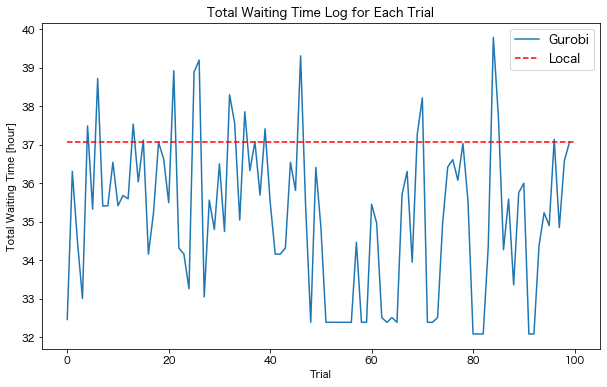

In [22]:
# Plotting the logged total_waiting_time
trial_log = [t.user_attrs['total_waiting_time']/3600 for t in study.trials]

plt.figure(figsize=(10, 6))
plt.plot(trial_log, label='Gurobi')
plt.xlabel('Trial')
plt.ylabel('Total Waiting Time [hour]')
plt.title('Total Waiting Time Log for Each Trial')

# 直線を引く
plt.plot([0, n_trials], [total_waiting_time/3600, total_waiting_time/3600], color='red', linestyle='dashed', label='Local')
plt.legend(fontsize=12)

plt.show()

In [14]:
import pickle

# 最適なパラメータを出力します。
best_params = study.best_params

# データを保存
with open("best_params.pickle", "wb") as f:
    pickle.dump(best_params, f)